In [ ]:
%matplotlib inline
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from itertools import islice
from Bio import pairwise2
from Bio import Seq
from Bio import SeqIO
from torch.utils.data import DataLoader,Dataset

In [ ]:
CUDA_FLAG = torch.cuda.is_available()
print(CUDA_FLAG)

False


In [ ]:
SEED = 1
torch.manual_seed(SEED)
if CUDA_FLAG:
    torch.cuda.manual_seed(SEED)

SEQ_LEN = 280
EMBEDDING_LEN = 140
NUM_TRAINING_PAIRS = 20 * 500
NUM_EPOCH = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 100

class Config():
    train_data_fp = './converted/pair_shuffle.fa'
    train_target_fp = './converted/dist_shuffle.txt'
    train_num_example = NUM_TRAINING_PAIRS
    train_batch_size = BATCH_SIZE
    num_epoch = NUM_EPOCH
    learning_rate =LEARNING_RATE

In [ ]:
class MaxMinout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, embedding1, embedding2):
        shape = list(embedding1.size())
        flat1 = embedding1.view(1, -1)
        flat2 = embedding2.view(1, -1)
        combined = torch.cat((flat1, flat2), 0)
        maxout = combined.max(0)[0].view(*shape)
        # minout = combined.min(0)[0].view(*shape)
        minout = ((combined * -1).max(0)[0].view(*shape) * -1) # workaround for memory leak bug

        return maxout, minout

class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxminout = MaxMinout()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
                
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
               
            nn.Conv1d(32, 48, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )
        max_pooling_len = SEQ_LEN 
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        max_pooling_len = np.floor((max_pooling_len - 2) / 2 + 1)
        self.fc = nn.Sequential(
            nn.Linear(int(48 * max_pooling_len), EMBEDDING_LEN),
        )

    def forward_one_side(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        embedding1 = self.forward_one_side(input1)
        embedding2 = self.forward_one_side(input2)
        maxout, minout = self.maxminout(embedding1, embedding2)
        return maxout, minout
  
    """
    #DEVE USARE MEMORIA DI MODELLO E STAMPARE TRATTINI
    def align_sequences(self, seq1, seq2):
        seq1_str = seq1_input
        seq2_str = seq2_input

        alignments = pairwise2.align.globalxx(seq1_str, seq2_str, one_alignment_only=True)
        aligned_sequence = alignments[0][0]
        alignment_score = alignments[0].score / len(aligned_sequence)

        # Converte la sequenza allineata in un vettore di one-hot
        aligned_sequence_tensor = torch.zeros((4, len(aligned_sequence)))
        for i, c in enumerate(aligned_sequence):
            if c in "ATCG":
                aligned_sequence_tensor["ATCG".index(c), i] = 1.0

        return aligned_sequence_tensor, alignment_score
    """

    def align_sequences(self, seq1_embedding, seq2_embedding):
        maxout, minout = self.maxminout(seq1_embedding, seq2_embedding)
        return maxout, minout

    def get_embedding(self, sequence):
        seq_tensor = torch.zeros((1, 4, SEQ_LEN))

        for i, c in enumerate(sequence):
            seq_tensor[0, atcg_map.get(c, 0), i] = 1.0

        if CUDA_FLAG:
            seq_tensor = seq_tensor.cuda()

        seq_tensor = Variable(seq_tensor)
        embedding = self.forward_one_side(seq_tensor)

        return embedding


In [ ]:
def weight_func(dist):
    return 1.0
#     return 100.0 if dist < 0.2 else 1.0


class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, maxout, minout, align_dist):
        weight = Variable(torch.FloatTensor([weight_func(x) for x in align_dist.data]), requires_grad=False)
        if CUDA_FLAG:
            weight = weight.cuda()
        loss_contrastive = torch.mean(torch.mul(weight, torch.pow(1 - minout.sum(1)/maxout.sum(1) - align_dist, 2)))

        return loss_contrastive

In [ ]:
atcg_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

class SiameseNetworkDataset(Dataset):
    def __init__(self, data_fp, target_fp, N):
        self.data_fp = data_fp
        self.target_fp = target_fp
        self.N = N
        self.data_tensor = self.gen_data_tensor()
        self.target_tensor = self.gen_target_tensor()
        
    def __getitem__(self, index):
        return self.data_tensor[0][index], self.data_tensor[1][index], self.target_tensor[index]

    def __len__(self):
        return self.N
    
    def gen_data_tensor (self):
        seq1 = torch.zeros((self.N, 4, SEQ_LEN))
        seq2 = torch.zeros((self.N, 4, SEQ_LEN))
        cnt = 0
        with open(self.data_fp) as f:
            while True:
                next_n = list(islice(f, 4))
                if not next_n:
                    break
                if cnt >= self.N:
                    break
                read1 = next_n[1].strip()
                read2 = next_n[3].strip()
                for i, c in enumerate(read1):
                    seq1[cnt, atcg_map.get(c, 0), i] = 1.0
                for i, c in enumerate(read2):
                    seq2[cnt, atcg_map.get(c, 0), i] = 1.0
                cnt += 1
        return seq1, seq2

    def gen_target_tensor(self):
        target = torch.zeros(self.N)
        with open(self.target_fp) as f:
            for i, line in enumerate(f):
                if i >= self.N:
                    break
                pair_id, dist = line.strip().split()
                target[i] = float(dist)
        return target



In [ ]:
net = SiameseNetwork()    
if CUDA_FLAG:
    net.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate, weight_decay=0)
print(net)

training_dataset = SiameseNetworkDataset(Config.train_data_fp, 
                                         Config.train_target_fp,
                                         Config.train_num_example)

training_loader = DataLoader(
    dataset=training_dataset,      
    batch_size=Config.train_batch_size,      
    shuffle=True,              
    num_workers=0,#4              
)

SiameseNetwork(
  (maxminout): MaxMinout()
  (cnn): Sequential(
    (0): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(32, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1680, out_features=140, bias=True)
  )
)


In [ ]:
train_num_batch = int(np.ceil(Config.train_num_example / Config.train_batch_size))
train_batch_interval = Config.train_num_example // Config.train_batch_size // 10
train_loss_hist = []

for epoch in range(Config.num_epoch):
    print('===========>')
    train_running_loss = 0
    for batch_index, (train_seq1, train_seq2, train_target) in enumerate(training_loader):
        if CUDA_FLAG:
            train_seq1 = train_seq1.cuda()
            train_seq2 = train_seq2.cuda()
            train_target = train_target.cuda()
        train_seq1 = Variable(train_seq1)
        train_seq2 = Variable(train_seq2)
        train_target = Variable(train_target).float()
        train_output1, train_output2 = net(train_seq1, train_seq2)
        train_loss_contrastive = criterion(train_output1, train_output2, train_target)
        #train_running_loss += train_loss_contrastive.data[0]
        train_running_loss += train_loss_contrastive.item()
        
        if batch_index % train_batch_interval == train_batch_interval - 1:
            print('Epoch: {:d}/{:d}, Batch: {:d}/{:d}\n'
                  'Accumulated loss: {:.4e}'.format(
                  epoch + 1, Config.num_epoch, 
                  batch_index + 1, train_num_batch, 
                  train_running_loss / (batch_index + 1)))
            
        optimizer.zero_grad()
        train_loss_contrastive.backward()
        optimizer.step() 
    train_loss = train_running_loss / train_num_batch
    train_loss_hist.append(train_loss)
    print('Train loss: {:.4e}'.format(train_loss))

===========>
Epoch: 1/10, Batch: 10/100
Accumulated loss: 3.5707e-01
Epoch: 1/10, Batch: 20/100
Accumulated loss: 2.1559e-01
Epoch: 1/10, Batch: 30/100
Accumulated loss: 1.7344e-01
Epoch: 1/10, Batch: 40/100
Accumulated loss: 1.5299e-01
Epoch: 1/10, Batch: 50/100
Accumulated loss: 1.3977e-01
Epoch: 1/10, Batch: 60/100
Accumulated loss: 1.3012e-01
Epoch: 1/10, Batch: 70/100
Accumulated loss: 1.2232e-01
Epoch: 1/10, Batch: 80/100
Accumulated loss: 1.1475e-01
Epoch: 1/10, Batch: 90/100
Accumulated loss: 1.0725e-01
Epoch: 1/10, Batch: 100/100
Accumulated loss: 9.8919e-02
Train loss: 9.8919e-02
===========>
Epoch: 2/10, Batch: 10/100
Accumulated loss: 1.0912e-02
Epoch: 2/10, Batch: 20/100
Accumulated loss: 1.0314e-02
Epoch: 2/10, Batch: 30/100
Accumulated loss: 9.7229e-03
Epoch: 2/10, Batch: 40/100
Accumulated loss: 9.5335e-03
Epoch: 2/10, Batch: 50/100
Accumulated loss: 9.3086e-03
Epoch: 2/10, Batch: 60/100
Accumulated loss: 8.9771e-03
Epoch: 2/10, Batch: 70/100
Accumulated loss: 8.6363e-0

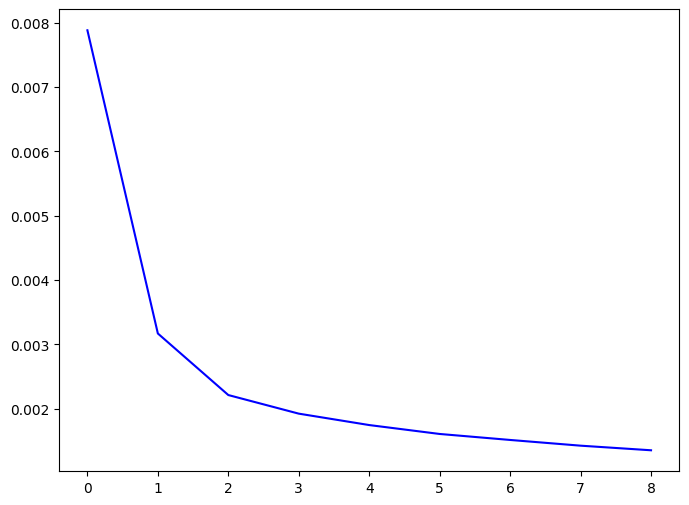

In [ ]:
def plot_loss():
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_hist[1:], 'b')
plot_loss()

In [ ]:
def jaccard_dist(embedding1, embedding2):
    return 1 - np.sum(np.minimum(embedding1, embedding2)) / np.sum(np.maximum(embedding1, embedding2)) 
    
def pair_dist(fp, N, embedding_fp, dist_fp):
    seq = torch.zeros((N, 4, SEQ_LEN))
    cnt = 0
    seq_ids = []
    with open(fp) as f:
        while True:
            next_n = list(islice(f, 2))
            if not next_n:
                break
            seq_id = next_n[0].strip()[1:]
            read = next_n[1].strip()
            seq_ids.append(seq_id)
            for i, c in enumerate(read):
                seq[cnt, atcg_map.get(c, 0), i] = 1.0
            cnt += 1
    embeddings = net.forward_one_side(Variable(seq)).data.numpy()
    embeddings.tofile(embedding_fp, sep=',', format='%.4e')
    with open(dist_fp, 'w') as fo:
        for i in range(N):
            for j in range(N):
                if i < j:
                    fo.write('{}-{}\t{:.4f}\n'.format(
                        seq_ids[i], seq_ids[j],
                        jaccard_dist(embeddings[i],
                                     embeddings[j])))

In [ ]:
def my_plot(align_dist_df, x_dist_df, save_fp):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.tick_params(axis='both', which='major', labelsize=15)
    vmin = align_dist_df[1].min()
    vmax = align_dist_df[1].max()
    percentile = 99

    hb = ax.hexbin(
        align_dist_df[1],
        x_dist_df[1],
        gridsize=200,
        bins='log',
        cmap='Blues',
        extent=(0, 1, 0, 1),
        norm=plt.Normalize(vmin=np.percentile(align_dist_df[1], 100 - percentile),
                           vmax=np.percentile(align_dist_df[1], percentile))
    )

    ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'r')
    ax.set_xlabel('alignment distance', fontsize=20)
    ax.set_ylabel('SENSE', fontsize=20)

    cbar_ax = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar_ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('log10(count + 1)', fontsize=20)
    fig.savefig(save_fp, bbox_inches='tight')   

/var/folders/x1/5w3j86893bg8f65k7gjw6jq00000gn/T/ipykernel_3804/1500876361.py:8: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  hb = ax.hexbin(


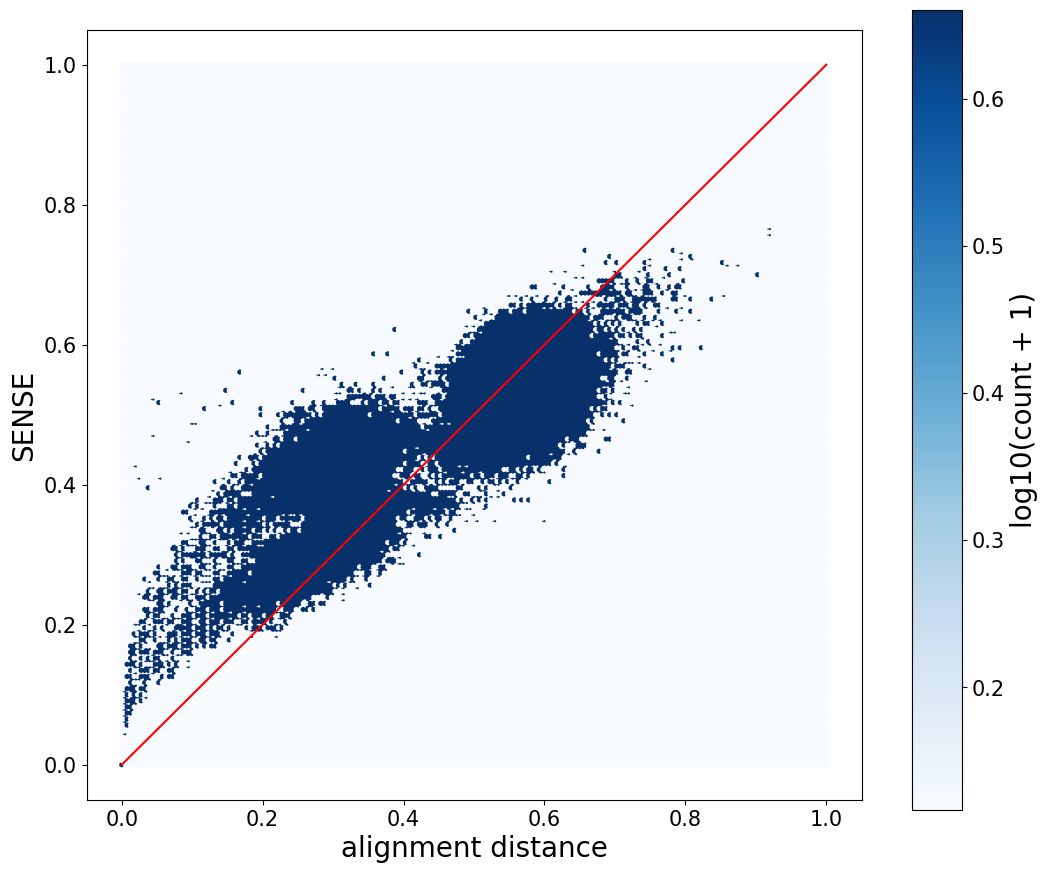

In [ ]:
# evaluation
NUM_EVAL_N = 500 # number of eval pairs is N*(N-1)/2
pair_dist('./converted/eval.fa', NUM_EVAL_N, './converted/embeddings.txt', './converted/embeddings_dist.txt')
nw_df = pd.read_csv('./converted/eval_dist.txt', sep='\t', header=None)
my_df = pd.read_csv('./converted/embeddings_dist.txt', sep='\t', header=None)
my_plot(nw_df, my_df, save_fp='./converted/demo.png')


In [ ]:
def tensor_to_atcg(tensor):
    atcg = "ATCG"
    return "".join([atcg[i] for i in tensor.argmax(dim=0)])

In [ ]:

import time

start_vero = time.time()
fasta = './converted/pair_shuffle.fa'
sequences = [str(record.seq) for record in SeqIO.parse(fasta, "fasta")]

# Effettua l'allineamento per ogni sequenza rispetto a tutte le altre sequenze
#for i in range(len(sequences)):
for i in range(4):
    start_time = time.time()
    seq1_embedding = net.get_embedding(sequences[i])

    # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
    best_score = float('inf')  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
    best_sequence = ""
    best_sequence_index = -1

    for j in range(len(sequences)):
        if i != j:  # Evita di confrontare una sequenza con se stessa
            seq2_embedding = net.get_embedding(sequences[j])

            maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

            # Calcola la distanza di allineamento
            alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

            # Aggiorna il punteggio migliore e la sequenza corrispondente se necessario
            if alignment_distance < best_score:
                best_score = alignment_distance
                best_sequence = sequences[j]
                best_sequence_index = j + 1  # Indice + 1 per ottenere il numero di sequenza

    # Ottieni l'allineamento tra la sequenza corrente e quella migliore
    alignment = pairwise2.align.globalxx(sequences[i], best_sequence, one_alignment_only=True)[0]
    formatted_alignment = pairwise2.format_alignment(*alignment)


    # Calcola la percentuale del numero di sequenza rispetto al totale
    percentage = (best_sequence_index / len(sequences)) * 100

    # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
    print(f"Per la sequenza {i + 1}:")
    print(f"Miglior punteggio di allineamento: {best_score}")
    print(f"Sequenza corrispondente: {best_sequence}")
    print(f"Numero di sequenza corrispondente: {best_sequence_index} su {len(sequences)} (percentuale: {percentage:.2f}%)")
    print(f"Allineamento:")
    print(formatted_alignment)
    end_time = time.time()
    tempo_effettivo = end_time - start_time
    print(tempo_effettivo)
    
tempo_finale = time.time() - start_vero
print(tempo_finale)
print()


Per la sequenza 1:
Miglior punteggio di allineamento: 0.19462686777114868
Sequenza corrispondente: GACACAGACGACAGAAAGAAAGAGAGAGACAGACAGACAGAAAAAGACAGAGACGGACAGAGAGAGACAGAGAAATAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGGGGGAGAGAGAGAGAAAGAAAGGGAGGGAGAGAGAGAGAGA
Numero di sequenza corrispondente: 14384 su 20000 (percentuale: 71.92%)
Allineamento:
CCTCTTTGCTCCC-CAC-G-CTTT--C-GA--GCCTCA--GC-GTCAGTTA--CA-ATC---CAGA----G-C-GCC-GCTTT-CGCC-ACC-G-GT-GTTCCTCCCTATCTCTCCGCATTTCACCGCTAC-ACC--T-G-GA-ATTCC-ACTCTCCCCTCTTGCACTCC-AGTTACCC-AGTTT-G-GA-A--------------------------------------------------
       |      ||| | |     | ||  |    |  |  |  ||  |  || | |   ||||    | | |   |     ||   | | | |  |         |       | |   ||  |  |  |    | | || |     |            | |     ||  |    ||    | || |                                                  
-------G-----ACACAGAC---GACAGAAAG----AAAG-AG--AG--AGACAGA-CAGACAGAAAAAGACAG--AG----ACG--GA-CAGAG-AG---------A-------G-A---CA--G--A-GA--AATAGAGAGA----GA------------G-A----GAG--A-

KeyboardInterrupt: 

In [ ]:

import torch
from torch.autograd import Variable
from Bio import SeqIO
import random
from deap import base, creator, tools, algorithms

start1 = time.time()

# Definisci il tipo di problema (minimizzazione)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Inizializza il toolbox
toolbox = base.Toolbox()

# Leggi sequenze genomiche da un file FASTA
input_file = './converted/pair_shuffle.fa'
num_sequences_to_select = 200

# Leggi tutte le sequenze dal file .fa
all_sequences = list(SeqIO.parse(input_file, "fasta"))

"""
# Seleziona casualmente 500 sequenze
selected_sequences = random.sample(all_sequences, num_sequences_to_select)
print(len(all_sequences))
"""

current_sequence_index = 0

def generate_individual():
    global current_sequence_index
    if current_sequence_index + 1 >= len(all_sequences):
        # Se tutte le sequenze sono state utilizzate, reimposta l'indice
        current_sequence_index = 0

    # Seleziona due sequenze consecutive
    seq1 = all_sequences[current_sequence_index]
    seq2 = all_sequences[current_sequence_index + 1]

    # Incrementa l'indice per la prossima chiamata
    current_sequence_index += 2

    return [seq1, seq2]
"""

# Crea una funzione per generare una coppia di sequenze genomiche
def generate_individual():
    return random.sample(all_sequences, 2)

"""

# Aggiungi la funzione di generazione dell'individuo al toolbox, viene utilizzato per inizializzare un individuo all'interno della popolazione
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)

# Crea una popolazione di individui, viene utilizzato toolbox.individual che crea il singolo individuo
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
net = SiameseNetwork()

# Definisci la funzione di fitness che calcola la distanza tra le sequenze
def evaluate(individual):
    seq1, seq2 = individual
    seq1_embedding = net.get_embedding(seq1)
    seq2_embedding = net.get_embedding(seq2)
    maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)
    distance = maxout.sum(1) / minout.sum(1)
    return distance.item(),

toolbox.register("evaluate", evaluate)

# Definisci gli operatori genetici (crossover e mutazione)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

# Imposta il numero di generazioni e la dimensione della popolazione
generations = 4
population_size = 10
popolazioni = 1
for i in range(popolazioni):
    print(f"\nRun {i + 1}:")
    # Esegui l'algoritmo genetico 10 volte
    for run in range(1):
        
        # Crea una popolazione iniziale
        pop = toolbox.population(n=population_size)
    
        # Esegui l'algoritmo genetico
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", min)
        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=generations, stats=stats, halloffame=None, verbose=True)
    
       # Stampa il miglior individuo per ogni generazione
        for gen in range(1):
            best_individual = tools.selBest(pop, 1)[0]
            best_fitness = best_individual.fitness.values[0]
            seq1, seq2 = best_individual
    
            print(f"Miglior Fitness = {best_fitness}")
            print(f"Miglior coppia di sequenze:")
            print(f"Seq1 ({seq1.id}): {seq1.seq}")
            print(f"Seq2 ({seq2.id}): {seq2.seq}")
            alignment = pairwise2.align.globalxx(seq1.seq, seq2.seq, one_alignment_only=True)[0]
            formatted_alignment = pairwise2.format_alignment(*alignment)
            print(f"Allineamento:")
            print(formatted_alignment)
    
    print("\n-------------------------------------")

end1 = time.time()
delta = end1 - start1
print(delta)


In [ ]:
import time
from Bio import SeqIO

start_vero = time.time()
fasta = './converted/pair_shuffle.fa'
all_sequences = [str(record.seq) for record in SeqIO.parse(fasta, "fasta")]
#sequences = random.sample(all_sequences, 500)
sequences= all_sequences[:500]
print(len(sequences))

# Inizializza un insieme di sequenze utilizzate
used_sequences = set()

# Lista per tenere traccia della catena delle sequenze ordinate decrescenti
ordered_sequence_chain = []
iterazioni = 20
print(iterazioni)

for i in range(iterazioni):
    # Seleziona la sequenza corrente come punto di partenza
    current_sequence_index = 0
    current_2 = 1
    prima_sequenza = sequences[current_sequence_index]
    print(prima_sequenza)
    current_sequence = sequences[current_2]

    # Se la sequenza è già stata utilizzata, passa alla prossima iterazione
    if current_2 in used_sequences:
        continue

    start_time = time.time()

    # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
    best_score = 0  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
    best_sequence = ""
    best_sequence_index = -1

    for j in range(len(sequences)):
        if current_sequence_index != j and j not in used_sequences:
            seq1_embedding = net.get_embedding(prima_sequenza)
            seq2_embedding = net.get_embedding(sequences[j])

            maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

            alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

            if alignment_distance > best_score:
                best_score = alignment_distance
                best_sequence = sequences[j]
                best_sequence_index = j

    # Aggiungi la sequenza corrente all'insieme delle sequenze utilizzate
    used_sequences.add(current_sequence)

    # Rimuovi la sequenza corrispondente dalla lista delle sequenze totali
    sequences.pop(best_sequence_index)
    print(best_sequence_index)

    # Ottieni l'allineamento tra la sequenza corrente e quella migliore
    alignments = pairwise2.align.globalxx(current_sequence, best_sequence, one_alignment_only=True)
    
    if alignments:
        alignment = alignments[0]
        formatted_alignment = pairwise2.format_alignment(*alignment)

    # Calcola la percentuale del numero di sequenza rispetto al totale
    percentage = (best_sequence_index + 1) / len(sequences) * 100

    # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
    print(f"Per la sequenza {current_sequence_index + 1}:")
    print(f"Miglior punteggio di allineamento: {best_score}")
    print(f"Sequenza corrispondente: {best_sequence}")
    print(f"Numero di sequenza corrispondente: {best_sequence_index + 1} su {len(sequences)} (percentuale: {percentage:.2f}%)")
    print(f"Allineamento:")
    print(formatted_alignment)
    end_time = time.time()
    tempo_effettivo = end_time - start_time
    print(f"Tempo effettivo: {tempo_effettivo:.2f} secondi")
    print()

    # Aggiungi la sequenza corrente alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(current_sequence)

    # Aggiungi la sequenza migliore alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(best_sequence)

tempo_finale = time.time() - start_vero
print(f"Tempo totale: {tempo_finale:.2f} secondi")

# Stampa la catena delle sequenze ordinate decrescenti
print("Catena delle sequenze ordinate decrescenti:")
for idx, sequence in enumerate(ordered_sequence_chain):
    print(f"Sequenza {idx + 1}: {sequence}")


439
Per la sequenza 1:
Miglior punteggio di allineamento: 0.42737212777137756
Sequenza corrispondente: TTAGAAACCCTGGTAGTCCGGCTGACTGACTCAGACTCTTCGGATATCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAACCAATAGTATCAATCATTAGCTGATTCAACAAAAAACCACATGCTGTTACAGCACAAAGAGTGTGAACATGT
Numero di sequenza corrispondente: 440 su 496 (percentuale: 88.71%)
Allineamento:
-------CC-TGTT-T-GCTCCCCACG-CTTTCG-C-GC-CTCAGTG--TCAGTTACAGGCCAAA-A----A-GCCGC-CTTC-GCC---A-----------CCGG--T-GTTCC-TCCTAATC-TCTACGCAT--TTCACCGCTACACTAGGAATT--CCACTT-TC-CTC-TCCTGCACTCCAGCCCATCC---GT--T-TCC-AA-----
       || ||   | | |   | || |  | | | |  ||||  |  ||  || | ||    | |    | ||||  |||| | |   |           ||    | | |   | | |||| | || || |  ||||     |||  |  ||    ||||   |  ||  |  |  |   |||  ||  |   |   | |   ||     
TTAGAAACCCTG--GTAG-T---C-CGGC--T-GACTG-ACTCA--GACTC--TT-C-GG----ATATCGTATGCCG-TCTTCTG-CTTGAAAAAAAAAAAACC--AATAG-T--AT-C-AATCAT-TA-GC-TGATTCA-----ACA--A--AA--AACCAC--AT-GCT-GT--T--A---CAG--CA--CAAAG-AGTGT--GAACATGT
  Score=89

Tempo eff

In [36]:

import time
from Bio import SeqIO

start_vero = time.time()
fasta = './converted/pair_shuffle.fa'
all_sequences = [str(record.seq) for record in SeqIO.parse(fasta, "fasta")]
#sequences = random.sample(all_sequences, 500)
sequences= all_sequences[:500]
print(len(sequences))

# Inizializza un insieme di sequenze utilizzate
used_sequences = set()

# Lista per tenere traccia della catena delle sequenze ordinate decrescenti
ordered_sequence_chain = []
iterazioni = 20
print(iterazioni)
prima_sequenza = sequences[25]
for i in range(iterazioni):
    # Seleziona la sequenza corrente come punto di partenza
    current_sequence_index = 0
    current_2 = 1
    #prima_sequenza = sequences[25]
    print("PRIMA:")
    print(prima_sequenza)
    current_sequence = sequences[current_2]

    # Se la sequenza è già stata utilizzata, passa alla prossima iterazione
    if current_2 in used_sequences:
        continue

    start_time = time.time()

    # Inizializza le variabili per il punteggio migliore e la sequenza corrispondente
    best_score = 0  # Inizializzato a infinito in modo che qualsiasi punteggio lo superi
    best_sequence = ""
    best_sequence_index = -1

    for j in range(len(sequences)):
        if current_sequence_index != j and j not in used_sequences:
            seq1_embedding = net.get_embedding(prima_sequenza)
            seq2_embedding = net.get_embedding(sequences[j])

            maxout, minout = net.align_sequences(seq1_embedding, seq2_embedding)

            alignment_distance = (minout.sum(1) / maxout.sum(1)).detach().cpu().numpy()[0]

            if alignment_distance > best_score:
                best_score = alignment_distance
                best_sequence = sequences[j]
                best_sequence_index = j

    # Aggiungi la sequenza corrente all'insieme delle sequenze utilizzate
    used_sequences.add(current_sequence)

    # Rimuovi la sequenza corrispondente dalla lista delle sequenze totali
    sequences.pop(best_sequence_index)
    print(best_sequence_index)

    # Ottieni l'allineamento tra la sequenza corrente e quella migliore
    alignments = pairwise2.align.globalxx(current_sequence, best_sequence, one_alignment_only=True)

    if alignments:
        alignment = alignments[0]
        formatted_alignment = pairwise2.format_alignment(*alignment)

    # Calcola la percentuale del numero di sequenza rispetto al totale
    percentage = (best_sequence_index + 1) / len(sequences) * 100

    # Stampa il punteggio migliore, la sequenza corrispondente e l'allineamento per la sequenza corrente
    print(f"Per la sequenza {current_sequence_index + 1}:")
    print(f"Miglior punteggio di allineamento: {best_score}")
    print(f"Sequenza corrispondente: {best_sequence}")
    print(f"Numero di sequenza corrispondente: {best_sequence_index + 1} su {len(sequences)} (percentuale: {percentage:.2f}%)")
    print(f"Allineamento:")
    print(formatted_alignment)
    end_time = time.time()
    tempo_effettivo = end_time - start_time
    print(f"Tempo effettivo: {tempo_effettivo:.2f} secondi")
    print()

    # Aggiungi la sequenza corrente alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(current_sequence)

    # Aggiungi la sequenza migliore alla catena delle sequenze ordinate decrescenti
    ordered_sequence_chain.append(best_sequence)

tempo_finale = time.time() - start_vero
print(f"Tempo totale: {tempo_finale:.2f} secondi")

# Stampa la catena delle sequenze ordinate decrescenti
print("Catena delle sequenze ordinate decrescenti:")
for idx, sequence in enumerate(ordered_sequence_chain):
    print(f"Sequenza {idx + 1}: {sequence}")

237
Per la sequenza 1:
Miglior punteggio di allineamento: 0.7041395306587219
Sequenza corrispondente: TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTTGAAACTGTTTAACTTGGGGGCAAGAGGGGGGAGGGGGATTCCGTGTT
Numero di sequenza corrispondente: 238 su 493 (percentuale: 48.28%)
Allineamento:
TACGTAGGTGGCA---AGCGTTGTCCGGATTTACT-GGGT-GTAAAG-G-GCGCGTAGGCGG---GCATGCAAGTCA-GAT-GTG-AAATCTGG--G-GGCTC-AACCCCCA-A--ACTGCATTT-GAAACTGTATGTA--TTGAGTGATGGC--G-GGGC---AGGCGGA-ATTCCCGG-G--
|||||||||  |    ||||||||||||||||| | |||  |||||| | ||||  ||||||   | ||  |||||  ||  ||  |||   ||  | ||||  ||   ||| |  || || ||| |||||||| | ||  ||| | |  |||  | |||    ||| ||  ||| || | |  
TACGTAGGT--C-CCGAGCGTTGTCCGGATTTA-TTGGG-CGTAAAGCGAGCGC--AGGCGGTTAG-AT--AAGTC-TGA-AGT-TAAA---GGCTGTGGCT-TAA---CCATAGTAC-GC-TTTTGAAACTGT-T-TAACTTG-G-G--GGCAAGAGGG-GGGAGG-GG-GATT-CC-GTGTT
  Score=118

Tempo effettivo: 3.59 secondi

PRIMA:
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCGCGCAGGCGGTTA